In [4]:
import sys
print(sys.executable)

/home/zhizuo/anaconda3/bin/python


# Lego Reproduce

In [5]:
#Pre-Processing

import os
import argparse
import networkx as nx
import math        
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time
def state_to_numpy(state):
    strlist = state.split()
    val_list = [float(s) for s in strlist]
    return np.array(val_list)

def list_all_dir(data_dir):
    task_dirs = os.listdir(data_dir)

    list_dir = []
    for task_dir in task_dirs:
        env_dirs = os.listdir(data_dir+"/"+task_dir)
        for env_dir in env_dirs:
            list_dir.append(data_dir +"/"+ task_dir +"/"+ env_dir)
    return list_dir  

def process_it(G, directory):
    start = np.loadtxt(directory+"/start_nodes.txt")
    goal = np.loadtxt(directory+"/goal_nodes.txt")
    occ_grid = np.loadtxt(directory+"/occ_grid.txt")
    path_nodes = []
    i = 0
    all_data = []
    with open(directory + "/path_nodes.txt", 'r') as file:
        lines  = file.readlines()
        for line in lines:
            line = line.strip('\n')
            
            s = state_to_numpy(G.nodes[str(int(start[i]))]['state'])
            g = state_to_numpy(G.nodes[str(int(goal[i]))]['state'])
            og = occ_grid[i]
            path_nodes = str(line).split(",")
            # print(path_nodes)
            for path_node in path_nodes:
                if(path_node=='-1'):
                    continue
                node_conf = state_to_numpy(G.nodes[path_node]['state'])
                curr_node = np.array([])

                curr_node = np.concatenate((node_conf, s, g, og))
                all_data.append(curr_node)
            i+=1
    return all_data

In [6]:
G = nx.read_graphml("graphs/dense_graph.graphml")

1975
1365
1974
1973
1972
1971
1970
1362
1968
1969


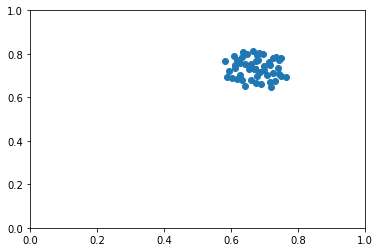

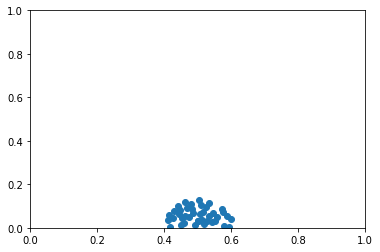

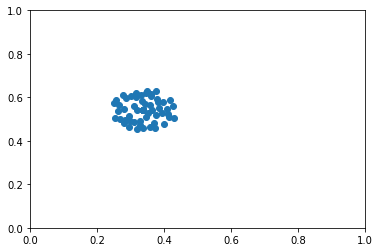

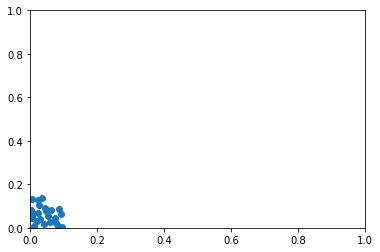

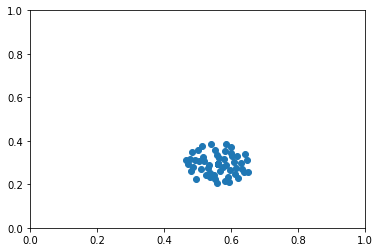

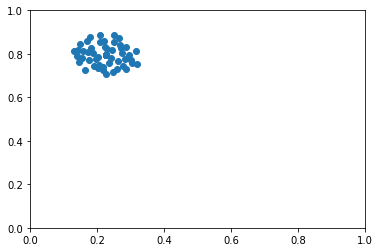

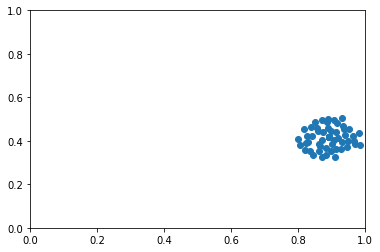

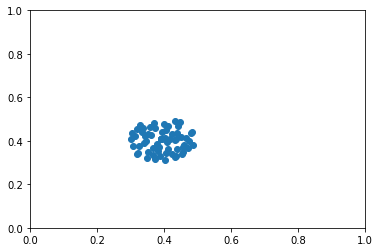

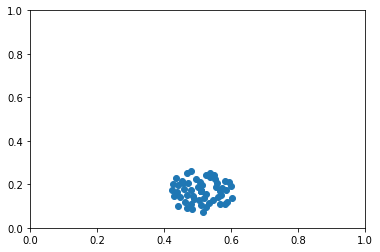

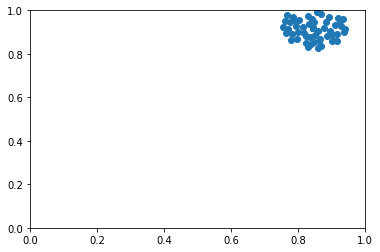

In [7]:
# Total 
#for i in G.nodes:
#    print(i)
node = [n for n in G.nodes()]
node = np.array(node)
#print(np.array(G.nodes[node[592]]['state']))

# print(node.shape) (2000,)
edge = [e for e in G.edges()]
edge = np.array(edge)
# print(edge.shape) (56382, 2)



for i in range(220, 230):
    plt.figure(i)
    print(node[i])
    tmp_edge = []
    for e in edge:
        if e[0] == node[i]:
            tmp_edge.append(e)
        if e[1] == node[i]:
            tmp_edge.append(e)

    point = []
    point.append(state_to_numpy((G.nodes[node[i]]['state'])))
    for e in tmp_edge:
        point.append(state_to_numpy((G.nodes[e[1]]['state'])))
    point = np.array(point)
    plt.xlim(xmin = 0, xmax = 1)
    plt.ylim(ymin = 0, ymax = 1)
    plt.scatter(point[:,1], point[:,0])



# Loading Data

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time


# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
#learning_rate
lr = 1e-4

#problem dimensions
dim = 2
dataElements = dim * 3 + 100

z_dim = 2 #latent
X_dim = dim # samples 2
y_dim = dim # reconstruction of the original point 2
c_dim = dataElements - dim # dimension of conditioning variable 104
print("X_dim = ", X_dim)
print("c_dim = ", c_dim)
print("y_dim = ", y_dim)


X_dim =  2
c_dim =  104
y_dim =  2


In [9]:
G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset"

directory = data_dir
print(directory)
final_data = []
flag = 0

data = np.array(process_it(G, directory))

#np.random.shuffle(data)
print("shape of array: ", data.shape)

numEntries = data.shape[0]

dataset
shape of array:  (21490, 106)


In [10]:
# split the inputs and conditions into test train
# to be processed in the next step into an occupancy grid representation
ratioTestTrain = 0.8;
numTrain = int(numEntries * ratioTestTrain) # 17192 = 0.8 * 21490

# state: x, y, z, xdot, ydot, zdot
X_train = data[0:numTrain, 0:dim]
# conditions: gaps, init(6), goal(6)
c_train = data[0:numTrain, dim:dataElements] 


X_test = data[numTrain:numEntries, 0:dim] # 17192 ~ 21490
c_test = data[numTrain:numEntries, dim:dataElements] # 17192 ~ 21490

numTest = X_test.shape[0]
print(numTest)
print(numTrain)

4298
17192


In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class LegoSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)
    

# CVAE Net

In [28]:
# define networks
print("X_dim = ", X_dim)
print("c_dim = ", c_dim)
print("y_dim = ", y_dim)
print()

import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(106, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(106, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
        self.fc1 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x, c):
        inputs = torch.cat((x, c), 1)
        outputs = self.encoder(inputs)
        z_mu = self.fc1(outputs)
        z_logvar = self.fc2(outputs)
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        
        inputs_1 = torch.cat((z,c), 1)
        outputs_1 = self.decoder(inputs_1)
        
        return z_mu, z_logvar, outputs_1
    

#net = CVAE()
#x1 = torch.FloatTensor(X_train[0])
#x2 = torch.FloatTensor(c_train[0])
#ret1, ret2, ret3 = net(x1,x2)
#ret1, ret2 = encoder_net(x1, x2)
#print(ret1.shape)
#print(ret2.shape)

'''
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(106, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
    def forward(self, z_mu, z_logvar, c):
        eps = torch.randn(size = z_mu.shape)
        z = z_mu + torch.exp(z_logvar / 2) * eps
        inputs = torch.cat((z,c), 0)
        outputs = self.decoder(inputs)
        return outputs
    
decoder_net = Decoder()
'''
#x1 = torch.FloatTensor(torch.randn(2))
#x2 = torch.FloatTensor(torch.randn(2))
#c = torch.FloatTensor(c_train[0])
#ret = decoder_net(z_mu = x1, z_logvar = x2, c = c)
#print(ret.shape)

        
        
        

X_dim =  2
c_dim =  104
y_dim =  2



'\nclass Decoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.decoder = nn.Sequential(\n            nn.Linear(106, 512),\n            nn.ReLU(inplace = True),\n            nn.Dropout(p = 0.5),\n            nn.Linear(512, 512),\n            nn.ReLU(inplace = True),\n            nn.Linear(512, 2),\n            nn.ReLU(inplace = True)\n        )\n    def forward(self, z_mu, z_logvar, c):\n        eps = torch.randn(size = z_mu.shape)\n        z = z_mu + torch.exp(z_logvar / 2) * eps\n        inputs = torch.cat((z,c), 0)\n        outputs = self.decoder(inputs)\n        return outputs\n    \ndecoder_net = Decoder()\n'

In [21]:
path = "/Users/zhangzhizuo/Desktop/UCSD/Su Lab/Code Lego/"
train_data = LegoSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)
test_data = LegoSet(x = X_test, c = c_test, train = False)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

        


In [22]:
def KL_loss(z_mu, z_logvar):
    return 2 * torch.sum(torch.exp(z_logvar) + 
                        z_mu**2 - 1. - z_logvar, dim=1).mean()
def Recon_loss(labels, predictions):
    loss = nn.MSELoss()
    return loss(labels, predictions)

In [23]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.current_device())
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#print(time.localtime(time.time()))

True
2
GeForce GTX 1080 Ti
0


# Training

In [29]:
from torch import optim
max_epoch = 10
lr = 1e-4
resume = "/home/zhizuo/lego/Model/lego2dCVAE_2020_3_4_0.pkl"
resume = None
net = CVAE()
if resume == None:
    net = CVAE()
else:
    net.load_state_dict(torch.load(resume))
if(torch.cuda.is_available()):
    net.cuda()
net.train()
optimizer = optim.Adam(net.parameters(), lr=3e-6, 
                      betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

for epoch in range(max_epoch):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0
    epoch_loss = 0.0
    for x, c in train_loader:
        i += 1
        batch_elements = [randint(0, numTrain - 1)
                         for n in range(0, 256)]
        
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-4
        #if epoch >= 100:
        #    beta = 10 ** -4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss += loss
        if i % 500 == 0:
            print("Epoch {} Batch {} loss: KL = {:.8f}, Recon = {:.6f}, Loss = {:.6f}".
              format(epoch + 1, i, kl_loss, recon_loss, loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / i
    print("Average loss of epoch {} Recon {:.8f} KL {:.8f} is {:.8f}".format(epoch + 1, epoch_loss, recon_loss, kl_loss))
    if (epoch + 1) % 500 == 0 and epoch >= 99:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(), 
                  '/home/zhizuo/lego/Model/lego2dCVAE_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE")
net.eval()             

Starting the 1 epoch
Average loss of epoch 1 Recon 0.13223919 KL 0.09374986 is 0.41071448
Starting the 2 epoch
Average loss of epoch 2 Recon 0.06277055 KL 0.03964456 is 0.79707927
Starting the 3 epoch
Average loss of epoch 3 Recon 0.04942283 KL 0.03633235 is 0.75712055
Starting the 4 epoch
Average loss of epoch 4 Recon 0.04837604 KL 0.03187409 is 0.67744404
Starting the 5 epoch
Average loss of epoch 5 Recon 0.04691632 KL 0.03981475 is 0.51254416
Starting the 6 epoch
Average loss of epoch 6 Recon 0.04642950 KL 0.05384281 is 0.39413843
Starting the 7 epoch
Average loss of epoch 7 Recon 0.04545270 KL 0.04282543 is 0.42553869
Starting the 8 epoch


KeyboardInterrupt: 

# Visualization

3789
(300, 104)
0.5111627125186338 0.9616721725656634
0.24749083751863377 0.16194652098815987


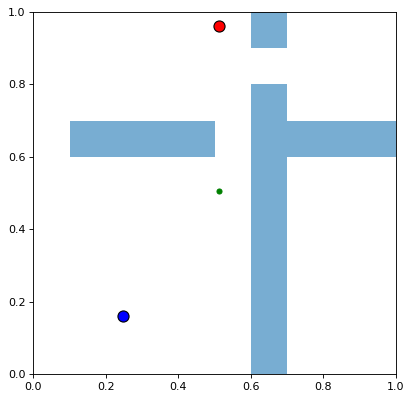

In [94]:
#net = CVAE()
#net.load_state_dict(torch.load(
#      "/home/zhizuo/lego/Model/lego2dCVAE_2019_12_27_16.pkl"))
num_viz = 300 # sample points of landmark
#vizIdx = randint(0, numTest - 1)
vizIdx = np.random.choice(range(4297))
#vizIdx = 88
print(vizIdx)
c_sample_seed = data[numTrain + vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
path = data[numTrain + vizIdx, 0:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))
c_sample_seed = torch.FloatTensor(c_sample_seed)
#print(y_viz)
for i in range(num_viz):
    #print(i)
    z = torch.FloatTensor(np.random.randn(2))
    #print("fuck")
    #print(z)
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))

y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(path[0], path[1], color = 'green', s = 20)
#plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
#plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

print(init[0], init[1])
print(goal[0], goal[1])
plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


# Visualization of more complex environment

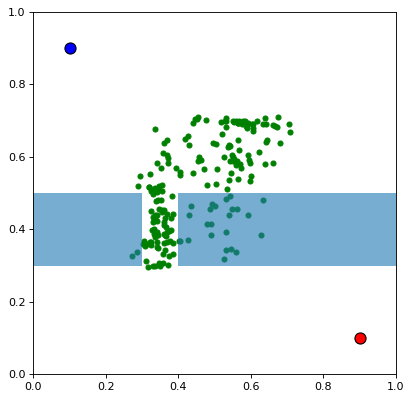

In [59]:
num_viz = 200 # sample points of landmark
c_sample_seed = np.array([0.9,0.1,0.1,0.9,1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1])
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]
# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))


y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
#plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()

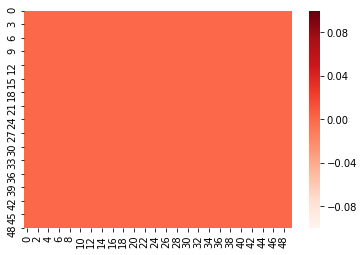

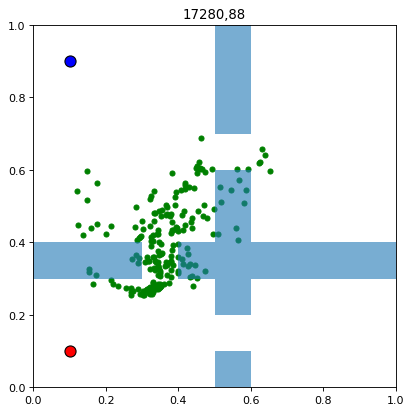

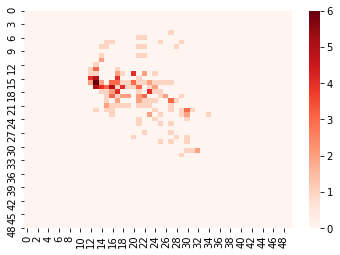

In [66]:
num_viz = 200 # sample points of landmark
import seaborn as sns
c_sample_seed = np.array([0.1,0.1,0.1,0.9,1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          0,1,0,0,0,0,1,0,0,0,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1])

occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]

# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)

grid = 50
heat_map = np.zeros((grid, grid));
    
        
sns.heatmap(heat_map, cmap = 'Reds')
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))
    

y_viz = y_viz.detach().numpy()
for i in range(num_viz):
    heat_map[int(y_viz[i][0]*grid)][int(y_viz[i][1]*grid)] += 1

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))
plt.show()
sns.heatmap(heat_map, cmap = 'Reds')
plt.show()

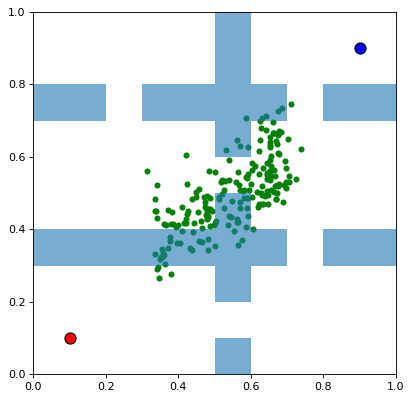

In [99]:
num_viz = 200 # sample points of landmark
c_sample_seed = np.array([0.1,0.1,0.9,0.9,1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          0,1,0,0,0,1,0,0,0,0,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1])

occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]

# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))


y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
#plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()

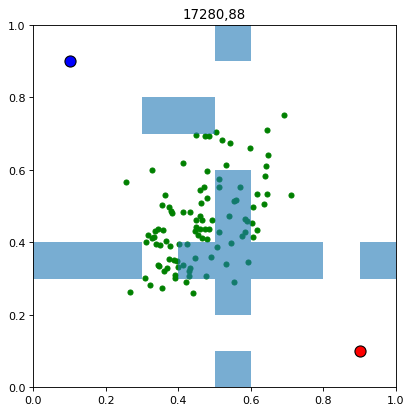

In [71]:
num_viz = 100 # sample points of landmark
c_sample_seed = np.array([0.9,0.1,0.1,0.9,1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          0,1,0,0,0,0,1,1,1,0,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1])

occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]

# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))


y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()

# Definition by using variance of Degree of freedom


In [18]:
graph = nx.Graph()
graph.add_node(1, coordinate = [1, 2])

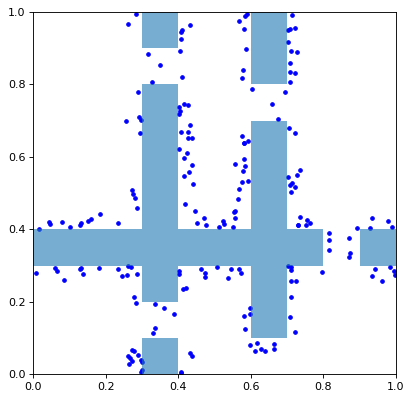

(488,)


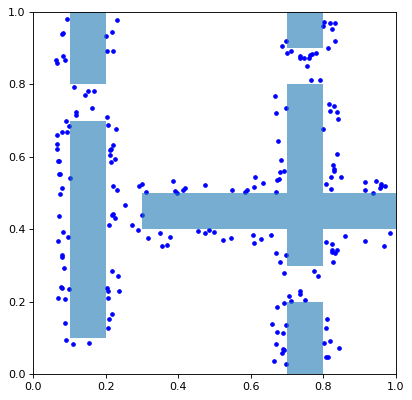

(502,)


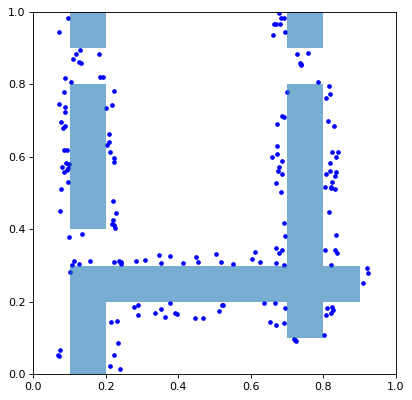

(438,)


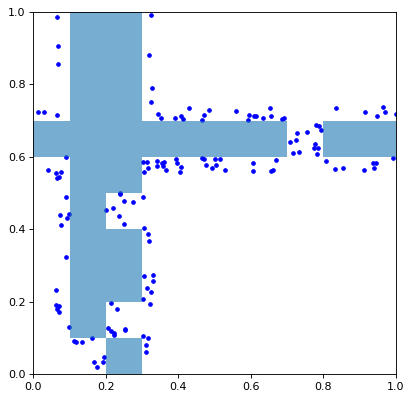

(380,)


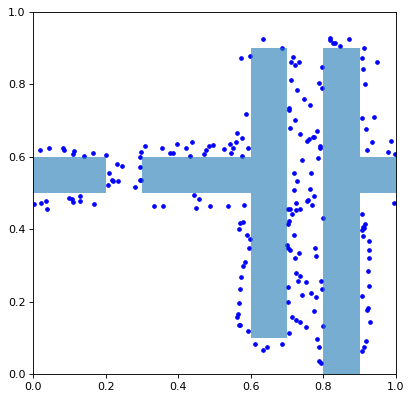

(494,)


In [109]:
import random

def get_rval(x):
    tmp = random.randint(0,99)
    if tmp%2:
        return random.randint(0,x-1)
    else:
        return random.randint(x+1,9)

def get_rval2(x):
    x1 = get_rval(x)
    x2 = get_rval(x)
    while abs(x1-x2)==1:
        x1 = get_rval(x)
        x2 = get_rval(x)
    return x1, x2

def get_random_occ_grid():
    row1 = random.randint(1,8)
    row2 = random.randint(1,8)
    while(row2 == row1 and row2 == row1 - 1 and row2 == row1 + 1):
        row2 = random.randint(1,8)
    col = random.randint(2,7)

    rc1, rc2 = get_rval2(col)
    cr1_1, cr1_2 = get_rval2(row1)
    cr2_1, cr2_2 = get_rval2(row2)

    occ_grid = np.ones((10,10))
    
    for i in range(10):
        if not (i==cr1_1 or i==cr1_2):
            occ_grid[row1,i] = 0

        if not (i==rc1 or i==rc2):
            occ_grid[i,col] = 0
            
        if not (i==cr2_1 or i==cr2_2):
            occ_grid[row2,i] = 0
            
            
    return occ_grid, row1, col
save_data = []
for num_data in range(5):
    data = occ_g.reshape(100)
    occ_g, row1, col = get_random_occ_grid()
    fig1 = plt.figure(figsize=(10,6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect = 'equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    num_landmark = 1000
    num_neighbor = 200
    radius_landmark = 0.7
    #landmark = np.zeros((num_landmark, 2))
    graph = nx.Graph()
    cnt = 0
    for i in range(num_landmark):
        x = np.random.uniform(0, 10)
        y = np.random.uniform(0, 10)
        if occ_g[int(x)][int(y)] == 0:
            continue

        ratio = 0.0
        minus = 0.0
        for j in range(num_neighbor):
            r = np.random.uniform(0, radius_landmark)
            theta = np.random.uniform(0, 2*np.pi)
            x_ = x + r * np.cos(theta)
            y_ = y + r * np.sin(theta)
            #print(int(x_), int(y_))
            if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
                minus += 1
                continue
            if occ_g[int(x_)][int(y_)] == 1:
                ratio += 1
        ratio = ratio / (num_neighbor - minus)
        graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
        if ratio <= 0.9:
            #print(ratio)
            data = np.append(data,x)
            data = np.append(data,y)
            plt.scatter(x/10, y/10, color = 'blue', s = 10)
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))

    plt.show()
    print(data.shape)
    np.save('/home/zhizuo/lego/dataset/landmark_{}.npz'.format(str(num_data)),data)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class LandmarkSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)

15992
(300, 104)


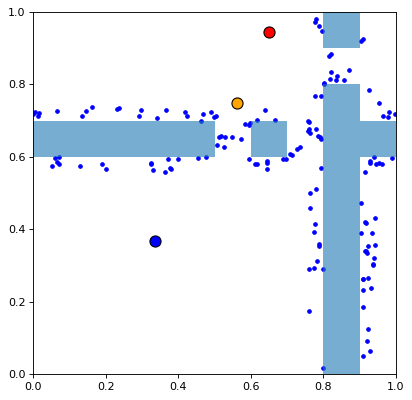

In [53]:
import networkx as nx
import operator

num_viz = 300
vizIdx = np.random.choice(range(4298+17192))
print(vizIdx)
c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]
path = data[vizIdx,0:2]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')


# ================
# variance of degree of freedom
# ================

num_landmark = 1000
num_neighbor = 200
radius_landmark = 0.7
#landmark = np.zeros((num_landmark, 2))
graph = nx.Graph()
cnt = 0
for i in range(num_landmark):
    x = np.random.uniform(0, 10)
    y = np.random.uniform(0, 10)
    if occ_g[int(x)][int(y)] == 0:
        continue
        
    ratio = 0.0
    minus = 0.0
    for j in range(num_neighbor):
        r = np.random.uniform(0, radius_landmark)
        theta = np.random.uniform(0, 2*np.pi)
        x_ = x + r * np.cos(theta)
        y_ = y + r * np.sin(theta)
        #print(int(x_), int(y_))
        if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
            minus += 1
            continue
        if occ_g[int(x_)][int(y_)] == 1:
            ratio += 1
    ratio = ratio / (num_neighbor - minus)
    graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
    if ratio <= 0.9:
        #print(ratio)
        plt.scatter(x/10, y/10, color = 'blue', s = 10)
    
plt.xlim(0,1)
plt.ylim(0,1)

plt.scatter(path[0], path[1], color="orange", s=100, edgecolors='black')
plt.scatter(init[0], init[1], color="red", s=100, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=100, edgecolors='black') # goal


for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


In [83]:
radius_check = 0.5
for i in list(graph.nodes()): 
    if i % 1000 == 0:
        print(i)
    for j in list(graph.nodes()):
        if i == j: 
            continue
        if np.linalg.norm(np.array(graph.nodes[i]['coordinate']) - np.array(graph.nodes[j]['coordinate'])) <= radius_check:
            graph.add_edge(i, j)
    
    
for i in list(graph.nodes()):
    mean = 0.0
    num = 0
    for j in graph.neighbors(i):
        ratio = graph.nodes[j]['rate']
        mean = mean + ratio
        num += 1
    if num == 0:
        continue
    mean = mean / num
    graph.nodes[i]['mean'] = mean

for i in list(graph.nodes()):
    var = 0
    mean = graph.nodes[i]['mean']
    cnt = 0
    for j in graph.neighbors(i):
        cnt += 1
        ratio = graph.nodes[j]['rate']
        var += (ratio - mean) * (ratio - mean)
    if cnt == 0:
        continue
    var /= cnt
    graph.nodes[i]['var'] = var
    
    

0


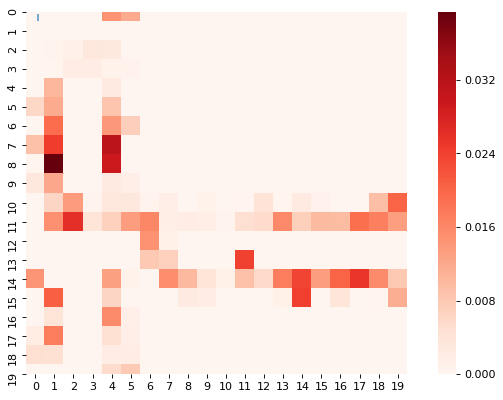

In [86]:
import seaborn as sns

'''
c_sample_seed = data[numTrain + vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
'''
#print(c_sample.shape)

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')
plt.xlim(0,1)
plt.ylim(0,1)

grid = 20
heat_map = np.zeros((grid, grid));
for i in list(graph.nodes()):
    var = graph.nodes[i]['var']
    if var >= 0.0:
        x = graph.nodes[i]['coordinate'][0]
        x /= 10
        y = graph.nodes[i]['coordinate'][1]
        y /= 10
        #plt.scatter(x, y, color = 'green', s = 10)
        heat_map[int(x*grid)][int(y*grid)] = var
        
sns.heatmap(heat_map, cmap = 'Reds')
for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))
plt.show()


In [136]:
layer = nn.ConvTranspose2d(2,1,10, stride=1,padding=0)
x = torch.randn(1,2,1,1)
print(x)
output = layer(x)
print(output.shape)

tensor([[[[0.7710]],

         [[1.2066]]]])
torch.Size([1, 1, 10, 10])


In [138]:
layer = nn.Conv2d(1,16,3,1,1)
x = torch.randn(1,1,10,10)
print(x.shape)
output = layer(x)
print(output.shape)

torch.Size([1, 1, 10, 10])
torch.Size([1, 16, 10, 10])
